In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings(action='ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as formula
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels as sm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
#from sklearn.externals import joblib
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from IPython.display import display

In [2]:
data = pd.read_csv('pune_19_23.csv',parse_dates =["date"])
data.head()

,City,PM2_5,PM10,NO,NO2,NOx,SO2,CO,Ozone,Benzene,...,SR,BP,VWS,Xylene,RF,TOT-RF,date,day,month,year
0,Pune,125.41,203.30,32.97,14.84,51.10,84.07,1.14,11.34,2.85,...,NaN,NaN,NaN,NaN,0.32,30.24,2019-01-01,1,1,2019
1,Pune,95.27,170.37,32.75,14.74,50.48,83.48,0.78,11.40,2.28,...,NaN,NaN,NaN,NaN,0.22,21.07,2019-02-01,2,1,2019
2,Pune,81.50,153.04,35.73,16.08,55.39,88.23,1.13,11.45,2.23,...,NaN,NaN,NaN,NaN,0.22,21.43,2019-03-01,3,1,2019
3,Pune,88.87,151.95,31.44,14.15,48.53,80.16,1.17,11.43,2.20,...,NaN,NaN,NaN,NaN,0.24,23.05,2019-04-01,4,1,2019
4,Pune,91.47,159.32,28.73,12.93,44.04,73.49,0.95,11.44,1.73,...,NaN,NaN,NaN,NaN,0.18,17.19,2019-05-01,5,1,2019


In [3]:
# drop the unwanted columns/features
cols_to_drop = ['City','RH','MP-Xylene','SR','BP','VWS','Xylene']
data = data.drop(cols_to_drop,axis=1)
# print out the info of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1551 entries, 0 to 1550
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   PM2_5    1131 non-null   float64       
 1   PM10     1132 non-null   float64       
 2   NO       1131 non-null   float64       
 3   NO2      1170 non-null   float64       
 4   NOx      1136 non-null   float64       
 5   SO2      1131 non-null   float64       
 6   CO       1177 non-null   float64       
 7   Ozone    1128 non-null   float64       
 8   Benzene  1173 non-null   float64       
 9   Toluene  685 non-null    float64       
 10  Temp     1088 non-null   float64       
 11  WS       1169 non-null   float64       
 12  WD       1093 non-null   float64       
 13  RF       627 non-null    float64       
 14  TOT-RF   1551 non-null   float64       
 15  date     1551 non-null   datetime64[ns]
 16  day      1551 non-null   int64         
 17  month    1551 non-null   int64   

In [4]:
# check for duplicated values and null values
print('Are there any duplicated values in our data ? : {}\n'.format(data.duplicated().any()))
print('The total number of null values in each colum:')
display(data.isnull().sum())

Are there any duplicated values in our data ? : False

The total number of null values in each colum:


PM2_5      420
PM10       419
NO         420
NO2        381
NOx        415
SO2        420
CO         374
Ozone      423
Benzene    378
Toluene    866
Temp       463
WS         382
WD         458
RF         924
TOT-RF       0
date         0
day          0
month        0
year         0
dtype: int64

In [5]:
# fill in the missing values with the mean of the particular column
data.fillna(value=data.mean(),inplace=True)
# let's check the data again if there are any missing values
data.isnull().any()

PM2_5      False
PM10       False
NO         False
NO2        False
NOx        False
SO2        False
CO         False
Ozone      False
Benzene    False
Toluene    False
Temp       False
WS         False
WD         False
RF         False
TOT-RF     False
date       False
day        False
month      False
year       False
dtype: bool

In [6]:
data.head()

,PM2_5,PM10,NO,NO2,NOx,SO2,CO,Ozone,Benzene,Toluene,Temp,WS,WD,RF,TOT-RF,date,day,month,year
0,125.41,203.30,32.97,14.84,51.10,84.07,1.14,11.34,2.85,1.57,27.36,0.28,124.75,0.32,30.24,2019-01-01,1,1,2019
1,95.27,170.37,32.75,14.74,50.48,83.48,0.78,11.40,2.28,1.14,32.81,0.28,122.43,0.22,21.07,2019-02-01,2,1,2019
2,81.50,153.04,35.73,16.08,55.39,88.23,1.13,11.45,2.23,1.15,32.50,0.28,124.11,0.22,21.43,2019-03-01,3,1,2019
3,88.87,151.95,31.44,14.15,48.53,80.16,1.17,11.43,2.20,1.21,32.12,0.28,116.17,0.24,23.05,2019-04-01,4,1,2019
4,91.47,159.32,28.73,12.93,44.04,73.49,0.95,11.44,1.73,0.88,36.54,0.28,132.06,0.18,17.19,2019-05-01,5,1,2019


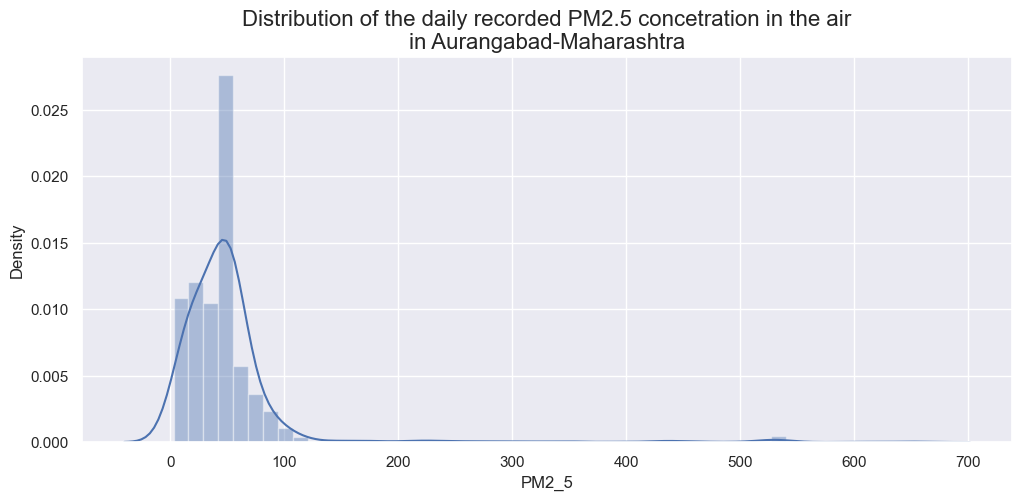

In [7]:
plt.figure(figsize=(12,5))
sns.distplot(data['PM2_5'],bins=50)
plt.title('Distribution of the daily recorded PM2.5 concetration in the air\nin Aurangabad-Maharashtra',
          fontsize=16)
plt.show()

In [8]:
import pandas as pd
import numpy as np

months = ['January','February','March','April','May','June','July',
         'August','September','October','November','December']

# convert 'month' column to categorical variable with specified category order
monthly_data = data[['month','PM2_5']]
#monthly_data['month'] = pd.Categorical(monthly_data['month'], categories=months, ordered=True)

# calculate monthly median of 'PM2_5'
monthly_average = monthly_data.groupby('month')['PM2_5'].median()

# round the values to one decimal place
monthly_average = np.round(monthly_average, 1)

# convert the resulting Series to a DataFrame
monthly_average = pd.DataFrame(monthly_average)

# set the index to the categorical variable and rename the column
monthly_average.index.name = 'month'
monthly_average.columns = ['median_PM2_5']

# display the resulting DataFrame
print(monthly_average)

       median_PM2_5
month              
1              51.4
2              51.4
3              48.0
4              50.6
5              51.4
6              26.3
7              23.5
8              23.7
9              20.8
10             45.1
11             51.4
12             51.4


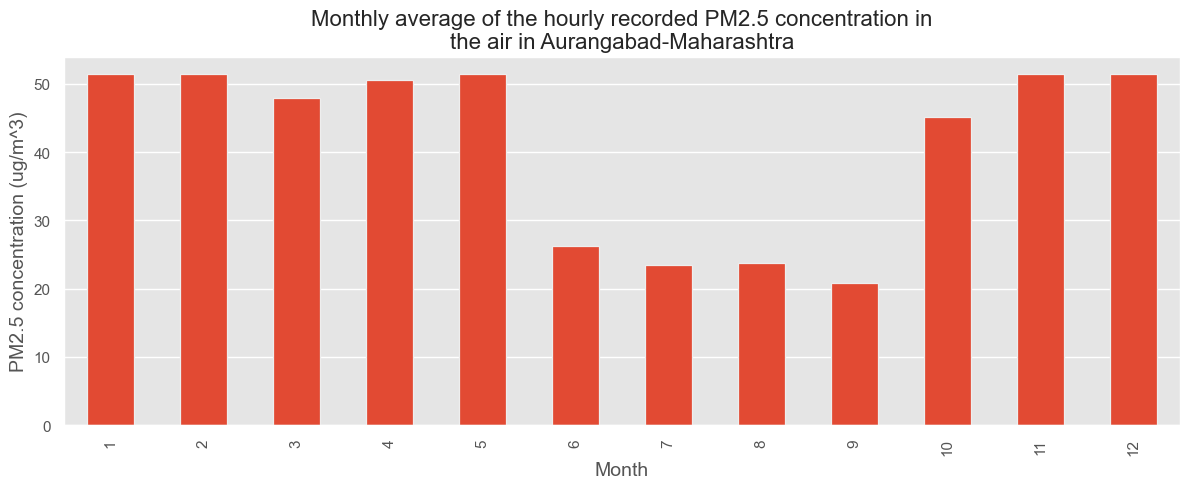

In [9]:
# plot the data
with plt.style.context('ggplot'):
    monthly_average.plot(figsize=(12,5),legend=False,kind='bar',linewidth=.9)
    plt.xlabel('Month',fontsize=14)
    plt.ylabel('PM2.5 concentration (ug/m^3)',fontsize=14)
    plt.title('Monthly average of the hourly recorded PM2.5 concentration in\nthe air in Aurangabad-Maharashtra',fontsize=16)
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

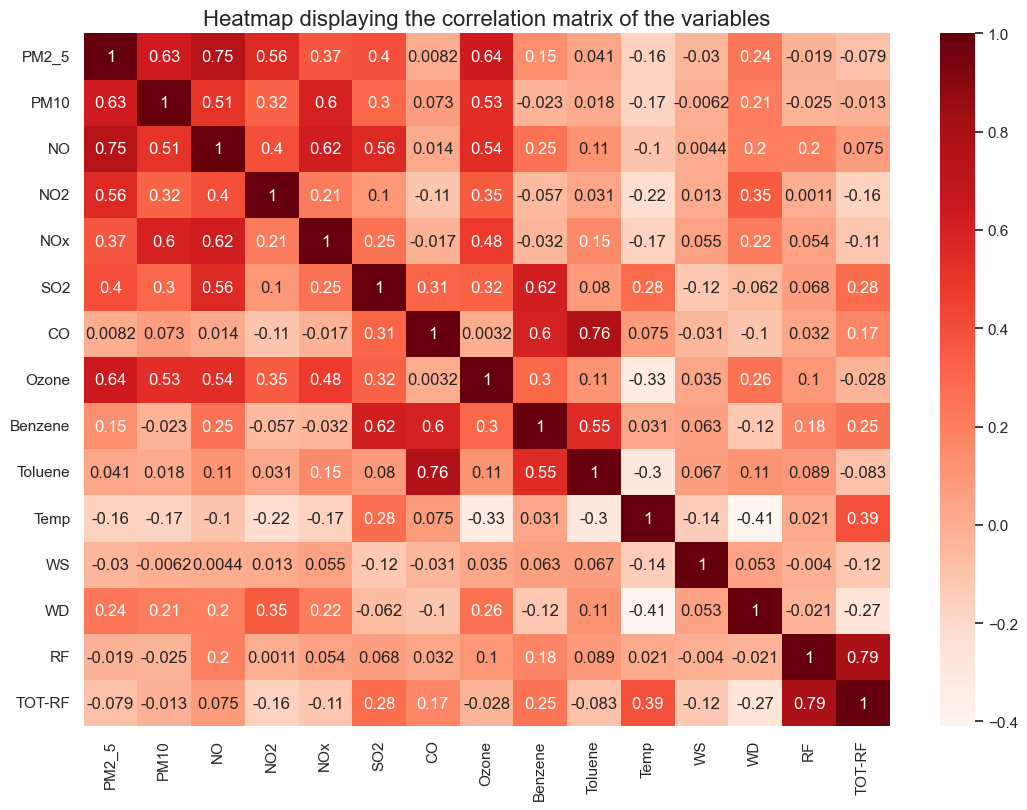

In [10]:
# let's try and visualize the relationships between the features of the data
plt.figure(figsize=(13,9))
correlation_data = data[['PM2_5', 'PM10', 'NO', 'NO2',
                         'NOx',  'SO2', 'CO',
                         'Ozone', 'Benzene', 'Toluene','Temp','WS','WD','RF','TOT-RF']]
sns.heatmap(correlation_data.corr(),cmap=plt.cm.Reds,annot=True)
plt.title('Heatmap displaying the correlation matrix of the variables',fontsize=16)
plt.show()

In [11]:
cols_to_drop = ['date','year','month','day']
newdata = data.drop(cols_to_drop,axis=1)

# calculate the variance inflation factor of each feature and detect multicollinearity
cons_data = sm.tools.add_constant(newdata)
series_before = pd.Series([variance_inflation_factor(cons_data.values,i) for i in range(cons_data.shape[1])],
                         index=cons_data.columns)
series_before

const      75.169361
PM2_5       5.732100
PM10        3.122000
NO          5.917518
NO2         1.676395
NOx         3.854137
SO2         4.316738
CO          5.469752
Ozone       2.927131
Benzene     5.051586
Toluene     6.800266
Temp        2.186631
WS          1.113640
WD          1.425789
RF          6.219123
TOT-RF      7.514249
dtype: float64

In [12]:
newdata.head()

,PM2_5,PM10,NO,NO2,NOx,SO2,CO,Ozone,Benzene,Toluene,Temp,WS,WD,RF,TOT-RF
0,125.41,203.30,32.97,14.84,51.10,84.07,1.14,11.34,2.85,1.57,27.36,0.28,124.75,0.32,30.24
1,95.27,170.37,32.75,14.74,50.48,83.48,0.78,11.40,2.28,1.14,32.81,0.28,122.43,0.22,21.07
2,81.50,153.04,35.73,16.08,55.39,88.23,1.13,11.45,2.23,1.15,32.50,0.28,124.11,0.22,21.43
3,88.87,151.95,31.44,14.15,48.53,80.16,1.17,11.43,2.20,1.21,32.12,0.28,116.17,0.24,23.05
4,91.47,159.32,28.73,12.93,44.04,73.49,0.95,11.44,1.73,0.88,36.54,0.28,132.06,0.18,17.19


In [13]:
columns_to_drop = ['WS','WD','RF','TOT-RF']

newdata = newdata.drop(columns_to_drop,axis=1)
cons_data2 = sm.tools.add_constant(newdata)
series_after = pd.Series([variance_inflation_factor(cons_data2.values,i) for i in range(cons_data2.shape[1])],
                         index=cons_data2.columns)
series_after

const      45.322363
PM2_5       5.173024
PM10        2.987089
NO          5.026243
NO2         1.594619
NOx         3.653918
SO2         3.845039
CO          4.677364
Ozone       2.830754
Benzene     4.586056
Toluene     5.731186
Temp        1.845083
dtype: float64

In [14]:
newdata.columns = ['PM2_5','PM10','NO','NO2','NOx','SO2','CO','Ozone','Temp','Benzene','Toluene']

# PM2.5 is skewed to the right so we log transform the values to normalize the distribution
newdata['PM2_5'] = np.log(newdata['PM2_5'])

In [15]:
mul_reg = formula.ols(formula="PM2_5 ~ PM10  + NO + NO2 + NOx + SO2 + CO + Ozone + Temp + Benzene + Toluene ",
                      data=newdata).fit()
mul_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PM2_5   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     421.7
Date:                Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                        13:44:21   Log-Likelihood:                -704.91
No. Observations:                1551   AIC:                             1432.
Df Residuals:                    1540   BIC:                             1491.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8080      0.065     43.478      0.000       2.681       2.935
PM10           0.0068      0.000     23.200      0.000       0.006       0.007
NO             0.0018      0.001      2.371      0.018       0.000       0.003
NO2            0.0008      0.000      6.357      0.000       0.001       0.001
NOx           -0.0062      0.001     -9.264      0.000      -0.007      -0.005
SO2            0.0113      0.001     15.675      0.000       0.010       0.013
CO          2.162e-05      0.001      0.027      0.978      -0.002       0.002
Ozone          0.0141      0.001     16.607      0.000       0.012       0.016
Temp          -0.0252      0.002    -11.297      0.000      -0.030      -0.021
Benzene        0.0159      0.002      6.939      0.000       0.011       0.020
Toluene       -0.0081      0.001     -5.609      0.000      -0.011      -0.005
==============================================================================
Omnibus:                      583.982   Durbin-Watson:                   0.697
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4646.544
Skew:                          -1.542   Prob(JB):                         0.00
Kurtosis:                      10.899   Cond. No.                         896.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# we split the data into predictor variables and Outcome variable
X = newdata.drop('PM2_5',axis=1)
y = newdata['PM2_5']

# we need to scale or normalize the predictor variables since they are not on the same
# scale and some of their distributions are skewed.
X_scaled =  preprocessing.scale(X)
X_scaled = pd.DataFrame(X_scaled,columns=X.columns)
X_scaled.dropna(inplace=True)
# print the scaled predictor variables.
X_scaled.head()

,PM10,NO,NO2,NOx,SO2,CO,Ozone,Temp,Benzene,Toluene
0,2.580645,0.459140,-0.301127,0.795262,1.950823,-0.515491,-0.688495,-0.265512,-0.986143,-0.790119
1,1.936093,0.449206,-0.302156,0.769408,1.928430,-0.529106,-0.685065,-0.327740,-1.028605,-0.189050
2,1.596886,0.583762,-0.288362,0.974158,2.108717,-0.515870,-0.682207,-0.333199,-1.027617,-0.223240
3,1.575551,0.390056,-0.308229,0.688092,1.802418,-0.514357,-0.683350,-0.336474,-1.021692,-0.265149
4,1.719807,0.267692,-0.320788,0.500856,1.549257,-0.522677,-0.682779,-0.387785,-1.054279,0.222323


In [17]:
y.head()

0    4.831588
1    4.556715
2    4.400603
3    4.487175
4    4.516011
Name: PM2_5, dtype: float64

In [18]:
# we now split out data into train and test data
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.3,random_state=0)

# instantiate the linear regression model
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)   # fit the model

LinearRegression()

In [19]:
ensemble_data = data.drop(cols_to_drop,axis=1)

# we split the data into predictor variables and Outcome variable
X = ensemble_data.drop('PM2_5',axis=1)
y = ensemble_data['PM2_5']

In [20]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=.3)

In [21]:
# we go ahead to use the ensemble methods as the LinearRegression model has a low accuracy
# on both the test and train data.
decision_tree = DecisionTreeRegressor(max_depth=5,
                                     max_features='auto',
                                     min_samples_split=3,
                                     min_samples_leaf=2)
decision_tree.fit(xtrain,ytrain)

DecisionTreeRegressor(max_depth=5, max_features='auto', min_samples_leaf=2,
                      min_samples_split=3)

In [22]:
# we now score the model
print('Score on train data: {}\n'.format(decision_tree.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(decision_tree.score(xtest,ytest)))

tree_pred = decision_tree.predict(xtest)
tree_mse = mean_squared_error(ytest,tree_pred)
tree_accuracy = r2_score(ytest,tree_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_mse)))
print('Overall model accuracy: {}'.format(tree_accuracy))

Score on train data: 0.9712977071249906

Score on test data: 0.726473031394302

Root Mean Squared Error: 35.842039789856344

Overall model accuracy: 0.726473031394302


In [23]:
# We now tune the parameters of the model to see if we can increase the accuracy
params = {'max_depth':[3,4,5,6,7],
         'max_features':['auto','sqrt','log2'],
         'min_samples_split':[2,3,4,5,6,7,8,9,10],
         'min_samples_leaf':[2,3,4,5,6,7,8,9,10]}

tree = DecisionTreeRegressor()

# initialize the grid search for the best parameters
tree_search = GridSearchCV(tree,param_grid=params,
                          n_jobs=-1,cv=5)

tree_search.fit(xtrain,ytrain)   # fit the model

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, 7],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]})

In [24]:
# we now score the model
print('Score on train data: {}\n'.format(tree_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(tree_search.score(xtest,ytest)))
print('Best parameters found:')
display(tree_search.best_params_)

tree_search_pred = tree_search.predict(xtest)
tree_search_mse = mean_squared_error(ytest,tree_search_pred)
tree_search_accuracy = r2_score(ytest,tree_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(tree_search_mse)))
print('Overall model accuracy: {}'.format(tree_search_accuracy))

Score on train data: 0.9109629388105391

Score on test data: 0.7379937050418264

Best parameters found:


{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 6}

Root Mean Squared Error: 35.079104998708

Overall model accuracy: 0.7379937050418264


In [25]:
dtpredicted=tree_search.predict(X)
df=pd.DataFrame({'Actual':y.tolist(),'Predicted from Decision_tree':dtpredicted.tolist()})
df.to_excel('decision_tree.xlsx')

In [26]:
# instantiate the RandomForestRegressor model and fit the model on the training data
forest = RandomForestRegressor(n_estimators=100,
                              max_depth=7,
                              max_features='auto',
                              min_samples_split=7,
                              min_samples_leaf=3)

forest.fit(xtrain,ytrain)

RandomForestRegressor(max_depth=7, min_samples_leaf=3, min_samples_split=7)

In [27]:
# we now score the model
print('Score on train data: {}\n'.format(forest.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest.score(xtest,ytest)))

forest_pred = forest.predict(xtest)
forest_mse = mean_squared_error(ytest,forest_pred)
forest_accuracy = r2_score(ytest,forest_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_mse)))
print('Overall model accuracy: {}'.format(forest_accuracy))

Score on train data: 0.9471726173618249

Score on test data: 0.8622641340928018

Root Mean Squared Error: 25.434087629874657

Overall model accuracy: 0.8622641340928018


In [28]:
# we now tune the parameters of the RandomForestRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['n_estimators'] = [100,200,300,400,500]

# instantiate the model
random_forest = RandomForestRegressor()

# perform the grid search for the best parameters
forest_search = RandomizedSearchCV(random_forest,params,n_jobs=-1,
                                   cv=5,verbose=2)
forest_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [29]:
# we now score the model
print('Score on train data: {}\n'.format(forest_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(forest_search.score(xtest,ytest)))
print('Best parameters found:')
display(forest_search.best_params_)

forest_search_pred = forest_search.predict(xtest)
forest_search_mse = mean_squared_error(ytest,forest_search_pred)
forest_search_accuracy = r2_score(ytest,forest_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(forest_search_mse)))
print('Overall model accuracy: {}'.format(forest_search_accuracy))

Score on train data: 0.9287687555502143

Score on test data: 0.8528289327604925

Best parameters found:


{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 5}

Root Mean Squared Error: 26.29080361134671

Overall model accuracy: 0.8528289327604925


In [30]:
rfpredicted=forest_search.predict(X)
df=pd.DataFrame({'Actual':y.tolist(),'Predicted from random_forest':rfpredicted.tolist()})
df.to_excel('randomforest.xlsx')

In [31]:
# instantiate the GradientBoostingRegressor model and fit the model on the training data
grad_boost = GradientBoostingRegressor(n_estimators=100,
                                      max_depth=7,
                                      max_features='auto',
                                      min_samples_split=7,
                                      min_samples_leaf=3,
                                      learning_rate=0.1)

grad_boost.fit(xtrain,ytrain)

GradientBoostingRegressor(max_depth=7, max_features='auto', min_samples_leaf=3,
                          min_samples_split=7)

In [32]:
# we now score the model
print('Score on train data: {}\n'.format(grad_boost.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(grad_boost.score(xtest,ytest)))

gboost_pred = grad_boost.predict(xtest)
gboost_mse = mean_squared_error(ytest,gboost_pred)
gboost_accuracy = r2_score(ytest,gboost_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_mse)))
print('Overall model accuracy: {}'.format(gboost_accuracy))

Score on train data: 0.9997265307329817

Score on test data: 0.8859177315774852

Root Mean Squared Error: 23.14737329445565

Overall model accuracy: 0.8859177315774852


In [33]:
# we now tune the parameters of the GradientBoostingRegressor model using RandomizedSearchCV to 
# find the best parameters and increase the accuracy of the model

params['learning_rate'] = np.linspace(0.1,1,10)

# instantiate the model
gradient_boosting = GradientBoostingRegressor()

# perform the grid search for the best parameters
gboost_search = RandomizedSearchCV(gradient_boosting,params,n_jobs=-1,
                                   cv=5,verbose=2)
gboost_search.fit(xtrain,ytrain)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'max_depth': [3, 4, 5, 6, 7],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   verbose=2)

In [34]:
# we now score the model
print('Score on train data: {}\n'.format(gboost_search.score(xtrain,ytrain)))
print('Score on test data: {}\n'.format(gboost_search.score(xtest,ytest)))
print('Best parameters found:')
display(gboost_search.best_params_)

gboost_search_pred = gboost_search.predict(xtest)
gboost_search_mse = mean_squared_error(ytest,gboost_search_pred)
gboost_search_accuracy = r2_score(ytest,gboost_search_pred)

print('Root Mean Squared Error: {}\n'.format(np.sqrt(gboost_search_mse)))
print('Overall model accuracy: {}'.format(gboost_search_accuracy))

Score on train data: 0.9992365143919368

Score on test data: 0.8791545073511976

Best parameters found:


{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 4,
 'learning_rate': 0.2}

Root Mean Squared Error: 23.823626389308973

Overall model accuracy: 0.8791545073511976


In [35]:
xgpredicted=gboost_search.predict(X)
df=pd.DataFrame({'Actual':y.tolist(),'Predicted from Xgboost':xgpredicted.tolist()})
df.to_excel('Xgboost.xlsx')

In [36]:
xgpredicted.tolist()
print(len(y.tolist()),len(xgpredicted.tolist()))

1551 1551
